Este notebook no se integró en Streamlit, pero se intento obtener mejores metricas que Machine Learning

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import itertools
import pickle

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Métodos de Validación
from sklearn.model_selection import train_test_split

# Métricas para Clasificación
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# OverSampling y UnderSampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#RNN
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dense,GRU, Input
from keras.layers import LeakyReLU
from tensorflow.keras.metrics import Accuracy, Precision, Recall

In [2]:
df = pd.read_pickle(r'C:\Users\Nahuel\Documents\hack_a_boss\mod7-streamlit-main\proyecto_aviones\data\pickle\vuelos_limpio.pkl')

In [3]:
# Creamos la columna target y ya la binarizamos
df["llega_tarde"] = np.where(df['retraso_llegada'] > 15, 'si', 'no')
df['llega_tarde'] = df['llega_tarde'].map({'si': 1, 'no': 0})

In [4]:
# # Eliminamos las columnas que no aportan información extra y retraso en la llegada para que no prediga el 100% de las veces y mes que solo tiene 1 valor
columnas_eliminar = [
    "latitude_destino",
    "latitude_origen",
    "longitude_destino",
    "longitude_origen",
    "codigo_aeropuerto_destino",
    "codigo_aeropuerto_origen",
    "direccion_destino",
    "direccion_origen",
    "retraso_llegada",
    "hora_llegada_real",
    "mes",
    'retraso_salida',
    'tiempo_retraso_aerolinea',
    'tiempo_retraso_sistema_aviacion',
    'hora_salida_real', 
    'hora_despegue', 
    'tiempo_pista_salida', 
    'duracion_real',
    'tiempo_retraso_clima',
    'festivos',
    'tiempo_retraso_seguridad']

df.drop(columns=columnas_eliminar, inplace=True)

In [5]:
df.groupby('llega_tarde').size().reset_index()

,llega_tarde,0
0,0,1560966
1,1,131510


In [6]:
# Cambiamos a minutos las columnas horarias
df["hora_salida_programada"] = df["hora_salida_programada"].apply(lambda x: x.hour * 60 + x.minute)

In [7]:
# Como da error el datetime de fecha, extraemos el día del mes, que es el único que nos falta, porque mes como todos tienen el mismo no hace falta
# y sobbreescribimos la columna de fecha, 
df['fecha'] = df['fecha'].dt.day

In [8]:
df_original = df.copy()

In [9]:
def target_encoding(df, columna_categorica, target):

    media_columna_con_target = df.groupby(columna_categorica)[target].mean()
    df[columna_categorica] = df[columna_categorica].map(media_columna_con_target)
    return

target_encoding(df, 'aerolinea', 'llega_tarde') 
target_encoding(df, 'numero_cola', 'llega_tarde')
target_encoding(df, 'ciudad_origen', 'llega_tarde')
target_encoding(df, 'estado_origen', 'llega_tarde')
target_encoding(df, 'aeropuerto_origen', 'llega_tarde')
target_encoding(df, 'ciudad_destino', 'llega_tarde')
target_encoding(df, 'estado_destino', 'llega_tarde')
target_encoding(df, 'aeropuerto_destino', 'llega_tarde')

Estos diccionarios serán necesarios a la hora de inputar datos externo al modelo de predección (para Streamlit).

In [10]:
# Crear el diccionario de mapeo
mapeo_aerolinea         = dict(zip(df_original['aerolinea'], df['aerolinea']))
mapeo_numero_cola       = dict(zip(df_original['numero_cola'], df['numero_cola']))
mapeo_ciudad_origen     = dict(zip(df_original['ciudad_origen'], df['ciudad_origen']))
mapeo_estado_origen     = dict(zip(df_original['estado_origen'], df['estado_origen']))
mapeo_aeropuerto_origen = dict(zip(df_original['aeropuerto_origen'], df['aeropuerto_origen']))
mapeo_ciudad_origen     = dict(zip(df_original['ciudad_destino'], df['ciudad_destino']))
mapeo_estado_origen     = dict(zip(df_original['estado_destino'], df['estado_destino']))
mapeo_aeropuerto_origen = dict(zip(df_original['aeropuerto_destino'], df['aeropuerto_destino']))

In [11]:
# Para variables discretas (tanto numéricas como categóricas, toman un conjunto finito o numerable de valores)

def comparar_variable_discreta_con_target(dataframe, target_variable, variable_to_compare):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    sns.countplot(x=dataframe[variable_to_compare], ax=axes[0])
    sns.countplot(x=dataframe[variable_to_compare], hue=dataframe[target_variable], ax=axes[1])
    plt.show()

In [12]:
# Para variables continuas (numéricas que pueden contener valores atípicos, que pueden variar dentro de un rango específico )
def comparar_variable_continua_con_target(dataframe, target_variable, variable_to_compare):
    fig, axes = plt.subplots(2, 2, figsize=(18, 11))
    sns.boxplot(x=dataframe[variable_to_compare], ax=axes[0, 0])
    axes[0, 0].set_title(f'{variable_to_compare} Boxplot')
    sns.histplot(x=dataframe[variable_to_compare], ax=axes[0, 1])
    axes[0, 1].set_title(f'{variable_to_compare} Histogram')
    sns.boxplot(x=dataframe[target_variable], y=dataframe[variable_to_compare], ax=axes[1, 0])
    axes[1, 0].set_title(f'{variable_to_compare} vs {target_variable}')
    sns.histplot(x=dataframe[variable_to_compare], hue=dataframe[target_variable], ax=axes[1, 1])
    axes[1, 1].set_title(f'{variable_to_compare} Histogram by {target_variable}')
    plt.tight_layout()
    plt.show()

In [13]:
# Aplicamos logaritmo.

df["distancia_millas"] = np.log(df["distancia_millas"] + 1) 
df['duracion_programada_vuelo'] = df["duracion_programada_vuelo"].apply(lambda x: 0 if x < 0 else np.log(x+1)) 

Trás unas cuantas comprobaciones en los modelos, observamos que las métricas eran mejor cuando `distancia_millas` era la única varibale continua a la que debíamos aplicar logaritmo.

In [14]:
# Definimos la target

TARGET = "llega_tarde"
X = df.drop(columns = TARGET)
y  = df[[TARGET]]

In [15]:
# Definimos train y test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1353980, 16), y_train: (1353980, 1)
X_test: (338496, 16), y_test: (338496, 1)


In [16]:
# Analizamos la distribución de clases en el conjunto de datos. 

contador_clases= Counter([arr[0] for arr in list(y_train.values)])
print(contador_clases)

total = sum(contador_clases.values())
for clase, count in contador_clases.items():
    porcentaje = (count / total) * 100
    print(f'Porcentaje de "{clase}": {porcentaje:.2f}%')

Counter({0: 1248772, 1: 105208})
Porcentaje de "0": 92.23%
Porcentaje de "1": 7.77%


### Se necesita balancear las clases porque están desbalanceadas con la técnica SMOTE (Synthetic Minority Oversampling Technique).
### Vamos a hacerlo híbrido, combinando oversampling y undersampling.

In [17]:
# Definir las estrategias de balanceo
undersampling = RandomUnderSampler(sampling_strategy=0.1)
oversampling = SMOTE(sampling_strategy=0.6)

# Definir la pipeline
balance_pipeline = Pipeline([
    ('undersampling', undersampling),
    ('oversampling', oversampling)
])

# Aplicar la pipeline al conjunto de entrenamiento
X_balanceado, y_balanceado = balance_pipeline.fit_resample(X_train, y_train)

In [18]:
# Comprobamos que se han balanceado más 
contador_clases= Counter([arr[0] for arr in list(y_balanceado.values)])
print(contador_clases)

total = sum(contador_clases.values())
for clase, count in contador_clases.items():
    porcentaje = (count / total) * 100
    print(f'Porcentaje de "{clase}": {porcentaje:.2f}%')

Counter({0: 1052080, 1: 631248})
Porcentaje de "0": 62.50%
Porcentaje de "1": 37.50%


In [19]:
X_balanceado.shape, y_balanceado.shape

((1683328, 16), (1683328, 1))

In [20]:
# Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_balanceado)
X_test = scaler.transform(X_test)

In [21]:
# Transformamos a np.array y ajustamos las dimensiones
# Para entrar en el modelo debe de tener 3 dimensiones
X_train_balanceado = np.array(X_train).reshape(-1, X_train.shape[1], 1)
y_train_balanceado = np.array(y_balanceado)
N = len(X_train_balanceado)


print(f"X_train: {X_train_balanceado.shape}\ty_train: {y_train_balanceado.shape}")

X_train: (1683328, 16, 1)	y_train: (1683328, 1)


In [22]:
X_test_balanceado = np.array(X_test).reshape(-1, X_test.shape[1], 1)
y_test_balanceado = np.array(y_test)
N = len(X_test_balanceado)


print(f"X_test: {X_test_balanceado.shape}\ty_test: {y_test_balanceado.shape}")

X_test: (338496, 16, 1)	y_test: (338496, 1)


In [23]:
# # Definir el modelo de red neuronal
# model = Sequential()

# model.add(Input(shape = (X_train.shape[1], 1)))

# model.add(GRU(units = 32, activation="relu", return_sequences=False))
# model.add(LeakyReLU(alpha = 0.1))  

# model.add(Dense(units = 60, activation="relu"))
# model.add(Dense(units = 30, activation="relu")) 
# model.add(Dense(units = 15, activation="relu"))

# model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con activación sigmoide para la clasificación binaria

# # Compilar el modelo
# model.compile(optimizer =   Adam(learning_rate = 0.0001), 
#               loss      =   'binary_crossentropy', 
#               metrics   =   ['accuracy'])

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# Definir el modelo de red neuronal
model = Sequential()
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(GRU(units=32, activation="relu", return_sequences=False))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))  # Agregamos dropout para regularización
model.add(Dense(units=60, activation="relu"))
model.add(Dropout(0.5))  # Más dropout para regularización
model.add(Dense(units=30, activation="relu"))
model.add(Dropout(0.5))  # Más dropout para regularización
model.add(Dense(units=15, activation="relu"))
model.add(Dropout(0.5))  # Más dropout para regularización
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con activación sigmoide para la clasificación binaria
# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

c:\Users\Nahuel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [33]:
# Mostrar arquitectura
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 60)             │         1,980 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,651 (29.89 KB)

 Trainable params: 7,651 (29.89 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Definir Callbacks
callback_val_loss = EarlyStopping(monitor = "val_loss", patience = 50)

# Entrenar el modelo
history = model.fit(X_train_balanceado, y_train_balanceado, epochs = 1_000, batch_size = 1_024, validation_data=(X_test_balanceado, y_test_balanceado), callbacks=[callback_val_loss])

Epoch 1/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5847 - loss: 0.6783 - val_accuracy: 0.9223 - val_loss: 0.5854
Epoch 2/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6156 - loss: 0.6677 - val_accuracy: 0.9223 - val_loss: 0.5701
Epoch 3/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.6215 - loss: 0.6643 - val_accuracy: 0.9223 - val_loss: 0.5622
Epoch 4/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6238 - loss: 0.6620 - val_accuracy: 0.9223 - val_loss: 0.5587
Epoch 5/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6251 - loss: 0.6602 - val_accuracy: 0.9223 - val_loss: 0.5563
Epoch 6/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6239 - loss: 0.6596 - val_accuracy: 0.9223 - val_loss: 0.5531
Epoch 7/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.6246 - loss: 0.6582 - val_accuracy: 0.9223 - val_loss: 0.5508
Epoch 8/1000
1644/1644 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - ac

In [35]:
# Evaluar el modelo
loss, accuracy = model.evaluate(X_test_balanceado, y_test_balanceado)
print(f'Loss: {loss}, Accuracy: {accuracy}')

# Hacer predicciones
predictions = model.predict(X_test_balanceado)

10578/10578 ━━━━━━━━━━━━━━━━━━━━ 8s 776us/step - accuracy: 0.5838 - loss: 0.5722
Loss: 0.5722055435180664, Accuracy: 0.5839448571205139
10578/10578 ━━━━━━━━━━━━━━━━━━━━ 8s 761us/step


10578/10578 ━━━━━━━━━━━━━━━━━━━━ 8s 773us/step


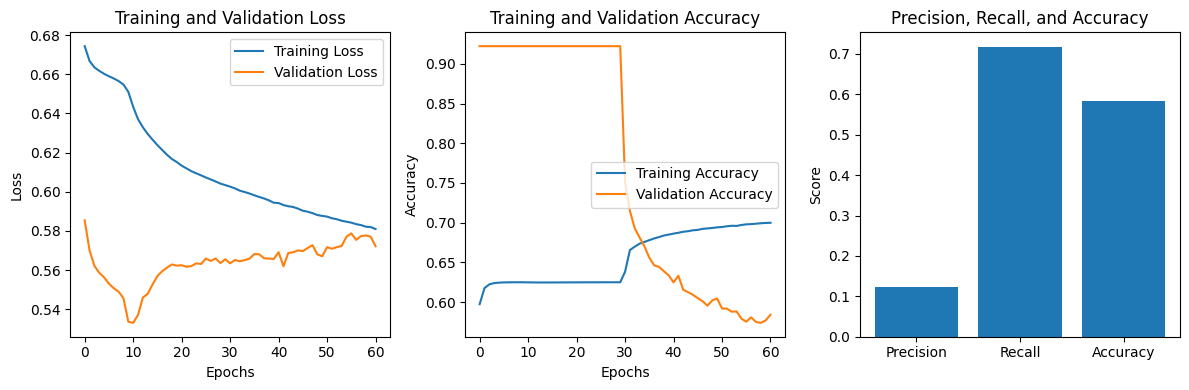

In [36]:
# Visualizar métricas de entrenamiento
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'],       label = 'Training Loss')
plt.plot(history.history['val_loss'],   label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'],       label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'],   label ='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Precisión, Recall y Exactitud
# Calcular las predicciones
y_pred = model.predict(X_test_balanceado)
y_pred_binary = (y_pred > 0.5).astype(int)

precision   = precision_score(y_test_balanceado, y_pred_binary)
recall      = recall_score(y_test_balanceado, y_pred_binary)
accuracy    = accuracy_score(y_test_balanceado, y_pred_binary)

plt.subplot(1, 3, 3)
plt.bar(['Precision', 'Recall', 'Accuracy'], [precision, recall, accuracy])
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy')

plt.tight_layout()
plt.show()

Luego de ver estas graficas, optamos por mantener el modelo de clasificacion.